In [1]:
import pandas as pd
import json
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

In [2]:
fontsize=14
class Category:
    Learned = 0
    Classic = 1
    Other = 2
def category_of(name):
    if name.lower() in {"alex", "pgm", "rmi", "rmicpp", "rmicpprobust", "rs", "ts", "cht"}:
        return Category.Learned
    elif name.lower() in {"btree", "fast", "art", "ibtree"}:
        return Category.Classic
    else:
        return Category.Other
markers={Category.Learned: "o", Category.Classic: "<", Category.Other: "x"}
ignore={"wormhole"}

In [3]:
df = None #pd.read_csv("name,variant,median_time,byte_size,build_time,searcher,dataset")
for file in os.listdir('./results'):
    if '.csv' not in file: 
        continue
    
    splice = pd.read_csv(f"./results/{file}", names=["name", "variant", "median_time", "byte_size", "build_time", "searcher", "dataset"])
    df = pd.concat([df, splice])

In [4]:
df["mbyte_size"] = df["byte_size"] / 1024**2
df["category"] = df.apply(lambda x : category_of(x["name"]), axis=1)

In [5]:
plt1_df = df[df["dataset"].isin(["books_200M_uint64", "fb_200M_uint64", "osm_cellids_200M_uint64", "wiki_ts_200M_uint64"])].copy(deep=True).reset_index()
plt1_df = plt1_df.sort_values(["category", "byte_size"])

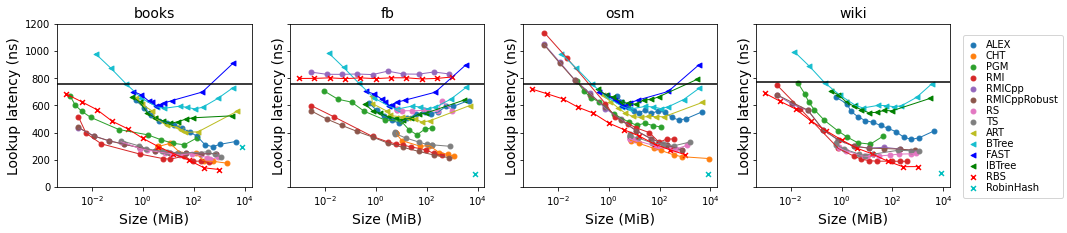

In [6]:
def plt1():
    datasets = set(plt1_df["dataset"])
    fig, axs = plt.subplots(1, len(datasets), figsize=(4 * len(datasets), 3), sharex=True, sharey=True)
    
    color_i = 0
    colors = {}
    for i, (ds, g) in enumerate(plt1_df.groupby(["dataset"])):  
        ax = axs[i]
        ax.set_title(ds[:ds.find("_", 0, -1)], fontsize=fontsize)
        ax.set_ylim(0, 1200)
        ax.set_xscale('log')
        
        for (category, fun), group in g.groupby(["category", "name"]):
            if fun.lower() in ignore:
                continue
            if fun == "BinarySearch":
                ax.axhline(y=list(group["median_time"])[0], color='black', linestyle='-')
                continue

            if fun not in colors:
                colors[fun] = (list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS))[i]
                i += 1
            ax.scatter(data=group, x="mbyte_size", y="median_time", label=fun, marker=markers[category], s=24, color=colors[fun])
            ax.plot(group["mbyte_size"], group["median_time"], color=colors[fun], linewidth=1)

        ax.set_xlabel("Size (MiB)", fontsize=fontsize)
        ax.set_ylabel("Lookup latency (ns)", fontsize=fontsize, x=0.05)
    
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=1, loc="center right", labelspacing=0.1, borderpad=0.5, handlelength=1)
    
    fig.savefig("pareto.pdf", bbox_inches="tight", dpi=300)
plt1()